In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs, plot_T_x
from epi.SSSN import SSSN_sim, SSSN_sim_traj, load_SSSN_variable, ISN_coeff
import tensorflow as tf
import pickle
import os
from epi.example_eps import load_W

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

In [2]:
D = 4
lb = -0.25*np.ones((D,))
ub = 0.25*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]
eps = 0.01

alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

max_H_paths = {}
max_H_ks = {}

sssn_sim_det = SSSN_sim(0.)
sssn_sim_rand = SSSN_sim(eps)

ind = 1070
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

### Plot simulations

In [3]:
sssn_sim_traj_det = SSSN_sim_traj(0.)
sssn_sim_traj_rand = SSSN_sim_traj(eps)

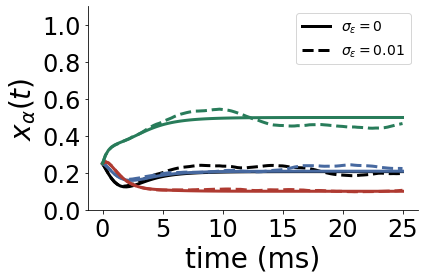

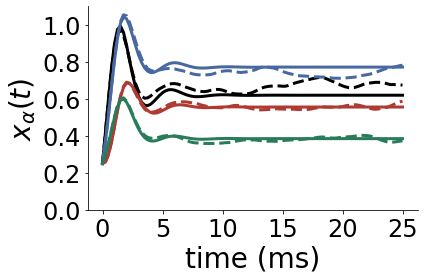

In [4]:
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/Fig3/"
dt = 0.00025
T = 100
t = dt*np.arange(T+1)

contrasts = [0., 1.]
panels = ['B', 'C']
ylims = [0., 1.1]

fontsize=28
for c_ind, contrast in enumerate(contrasts):
    fig, ax = plt.subplots(1,1)
    for neuron in alphas:
        H = (hb + contrast*hc)[None,:]
        r_t_det = sssn_sim_traj_det(H)[0,0,:4]
        r_t_rand = sssn_sim_traj_rand(H)[0,0,:4]
        ind = neuron_inds[neuron]
        if c_ind == 0 and neuron == 'E':
            label_det = r'$\sigma_{\epsilon} = 0$'
            label_rand = r'$\sigma_{\epsilon} = %.2f$' % eps
        else:
            label_det = None
            label_rand = None
        ax.plot(1e3*t, r_t_det[ind], '-', c=colors[ind], 
                 lw=3, label=label_det)
        ax.plot(1e3*t, r_t_rand[ind], '--', c=colors[ind], 
                 lw=3, label=label_rand)
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
    if (c_ind == 0):
        ax.legend()
    ax.set_ylim(ylims)
    plt.tight_layout()
    plt.savefig(figdir + "3%s.png" % panels[c_ind])
    plt.show()

In [5]:
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/Fig3/"
N = 200
sssn_sim_rand = SSSN_sim(eps, N=N)

contrasts = np.linspace(0. ,1., 51)[:,None]
h = (hb[None,:] + contrasts*hc[None,:])
isn_coeffs = np.array([ISN_coeff(np.zeros((1,4)), _h[None,:])[0].numpy() for _h in h])
x_t = sssn_sim_rand(h)
mean_x_t = np.mean(x_t, axis=1)
std_x_t = np.std(x_t, axis=1)

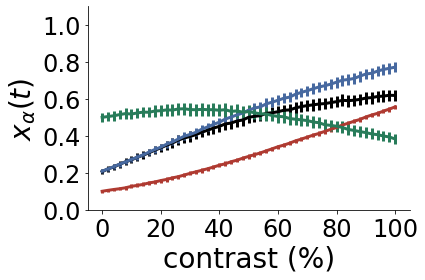

In [6]:
fig, ax = plt.subplots(1,1)
for neuron in alphas:
    ind = neuron_inds[neuron]
    plt.errorbar(100*contrasts, mean_x_t[:,ind], std_x_t[:,ind], c=colors[ind], lw=3)
plt.xlabel('contrast (%)', fontsize=fontsize)
plt.ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
plt.ylim(ylims)
plt.tight_layout()
plt.savefig(figdir + "3D.png")
plt.show()

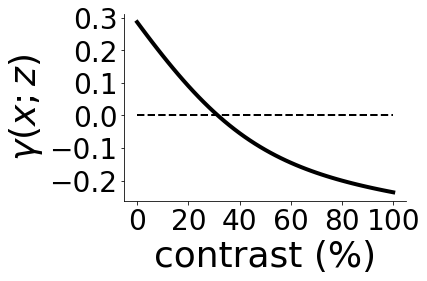

In [7]:
fig, ax = plt.subplots(1,1)
plt.plot(100*contrasts, isn_coeffs, 'k-', lw=4)
plt.plot([0, 100], [0, 0], 'k--')
plt.xlabel('contrast (%)', fontsize=(fontsize+8))
plt.ylabel(r'$\gamma(x; z)$', fontsize=(fontsize+8))
plt.setp(ax.get_xticklabels(), fontsize=(fontsize))
plt.setp(ax.get_yticklabels(), fontsize=(fontsize))
plt.tight_layout()
plt.savefig(figdir + "3Dsub.png")
plt.show()

### EPI distributions

E 0.0
P 0.0
S 0.0
V 0.0


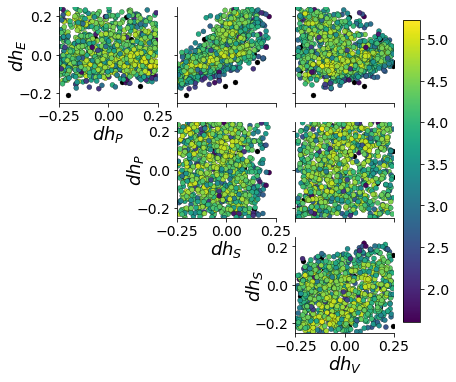

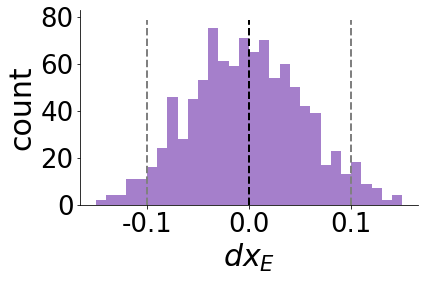

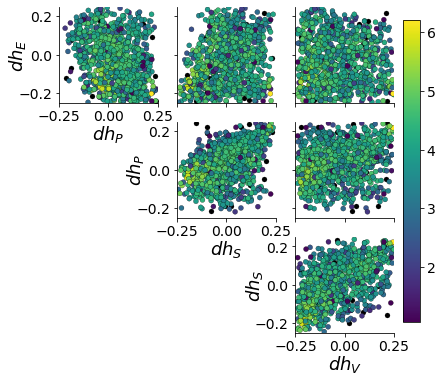

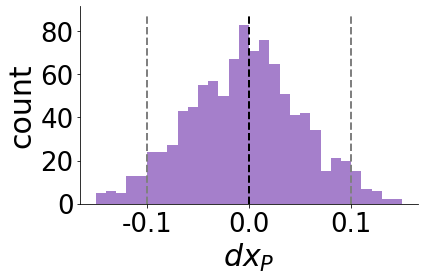

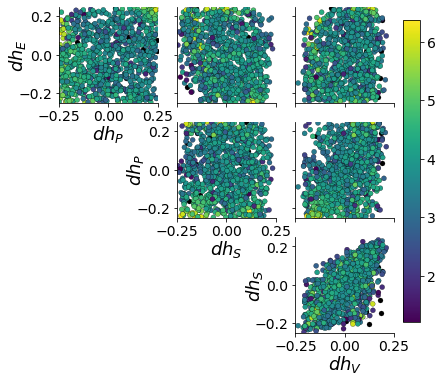

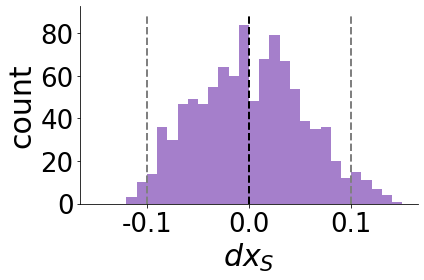

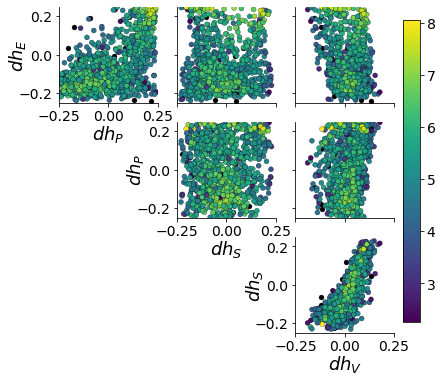

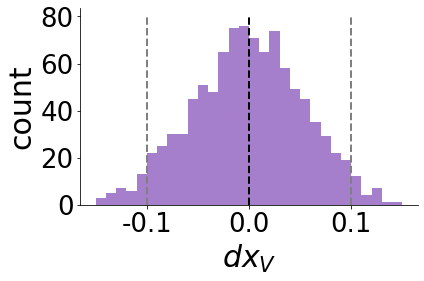

In [12]:
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"
M = 1000
beta = 4.
c0 = 1e2
eps = 0.01


# Define model
alphas = ['E', 'P', 'S', 'V']
contrasts = [0.]

mu_std = 0.05
mu = np.array([0., mu_std**2])

sssn_sim = SSSN_sim(eps)

max_H_fname = "max_H.pkl"
if os.path.exists(max_H_fname):
    with open(max_H_fname, "rb") as f:
        max_H_file = pickle.load(f)
    max_H_paths = max_H_file['max_H_paths']
    max_H_ks = max_H_file['max_H_ks']
else:
    max_H_paths = {}
    max_H_ks = {}

nu = 0.25
for contrast in contrasts:
    H = (hb + contrast*hc)[None,:]
    for alpha in alphas:
        print(alpha, contrast)
        neuron_ind = neuron_inds[alpha]
        if alpha == 'P' and contrast == 1. and eps == 0.01:
            random_seeds = range(1,11)
        else:
            random_seeds = [1,2,3]

        name = "SSSN_drdh_%s_c=%.1f_eps=%.3f" % (alpha, contrast, eps)
        dh = Parameter("dh", D, lb=lb, ub=ub)
        parameters = [dh]
        model = Model(name, parameters)

        # Define eps
        def dr(dh):
            x1 = sssn_sim(H + tf.zeros_like(dh))[:,:,neuron_ind]
            x2 = sssn_sim(H + dh)[:,:,neuron_ind]

            diff = tf.reduce_mean(x2 - x1, axis=1)
            T_x = tf.stack((diff, diff ** 2), axis=1)

            return T_x

        model.set_eps(dr)

        epi_df = model.get_epi_df()
        epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
        epi_df['lb'] = [arch['lb'][0] for arch in epi_df['arch']]
        epi_df['bnmom'] = [arch['bn_momentum'] for arch in epi_df['arch']]
        epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
        epi_df['rs'] = [arch['random_seed'] for arch in epi_df['arch']]
        epi_df['mu'] = [ep['mu'] for ep in epi_df['EP']]
        epi_df['mu_std'] = [np.sqrt(ep['mu'][1]) for ep in epi_df['EP']]

        epi_df2 = epi_df[(epi_df['c0']==c0) 
                   & (epi_df['lb']==model.parameters[0].lb[0])
                   & (epi_df['bnmom']==0.)
                   & (epi_df['beta']==beta)
                   & (epi_df['rs'].isin(random_seeds))
                   & (epi_df['mu_std']==mu_std)]
        
        if (alpha, contrast, eps) in max_H_paths.keys():
            path = max_H_paths[(alpha, contrast, eps)]
            best_k = max_H_ks[(alpha, contrast, eps)]
        else:
            paths = sorted(epi_df2['path'].unique())
            path, best_k = model.get_max_H(mu, nu, paths)
            max_H_paths.update({(alpha, contrast, eps): path})
            max_H_ks.update({(alpha, contrast, eps): best_k})

        epi_df2 = epi_df[epi_df['path'] == path]
        df_row = epi_df2.iloc[0].copy()
        dist = model.get_epi_dist(df_row, k=best_k)

        z, log_q_z = dist.nf(M)
        T_x = model.eps(z).numpy()
        z = z.numpy()
        log_q_z = log_q_z.numpy()

        neurons = [alpha for alpha in neuron_inds.keys()]
        labels = [r'$dh_%s$' % alpha for alpha in neurons]
        fig, axs, = pairplot(z, range(4), labels, s=25, figsize=(6,6),
                             fontsize=18, lb=dist.nf.lb, ub=dist.nf.ub,
                             outlier_stds=3, labelpads=(0,-10),
                             c=log_q_z, c_label='')
        plt.savefig(figdir + name + '_z.png')

        plot_T_x(None, T_x[:,0], x_mean=0., x_std=mu_std, 
                 xmin=-3.*mu_std, xmax=3.*mu_std, 
                 xlabel=r'$dx_%s$' % alpha, fontsize=30)
        plt.tight_layout()
        plt.savefig(figdir + name + '_Tx.png')
        
with open(max_H_fname, "wb") as f:
    pickle.dump({'max_H_paths':max_H_paths, 'max_H_ks':max_H_ks}, f)

## EPI distribution of ISN coefficients

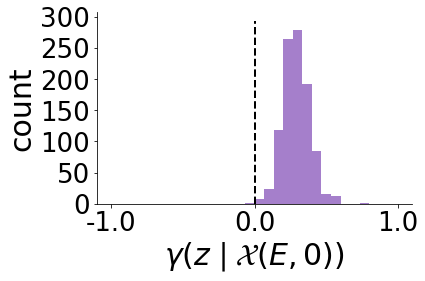

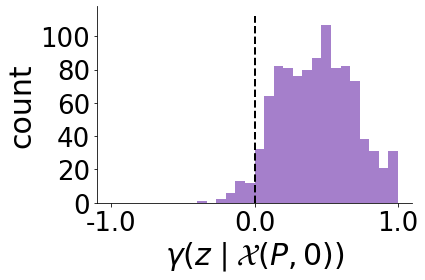

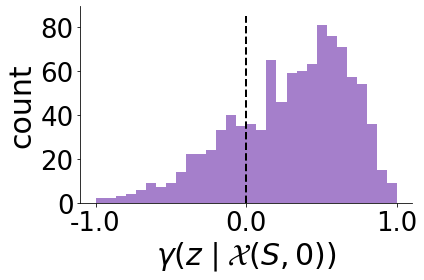

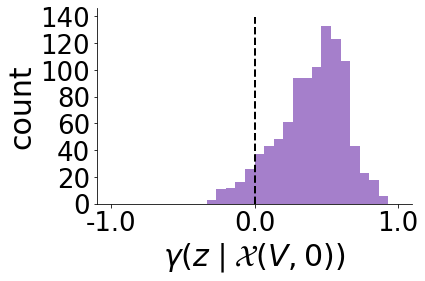

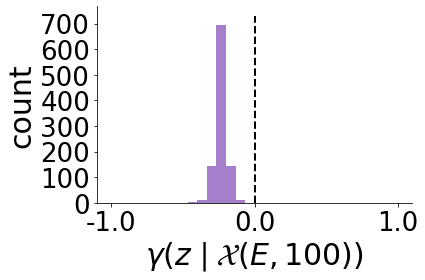

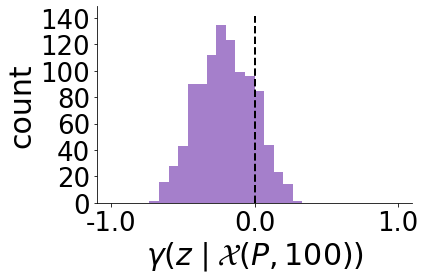

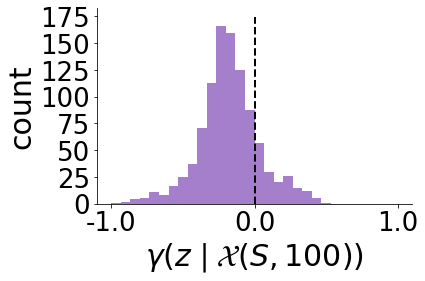

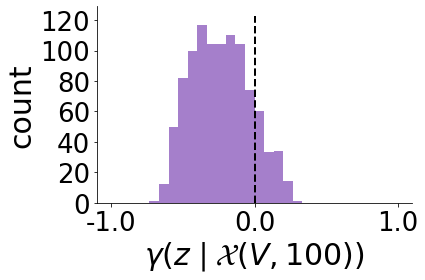

In [112]:
M = 1000
beta = 4.
c0 = 1e2
eps = 0.01

sssn_sim = SSSN_sim(eps)


# Define model
alphas = ['E', 'P', 'S', 'V']
contrasts = [0., 1.]
eps = 0.01

ind = 1070
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"
mu_std = 0.05
mu = np.array([0., mu_std**2])

nu = 0.25
for contrast in contrasts:
    H = (hb + contrast*hc)[None,:]
    for alpha in alphas:
        neuron_ind = neuron_inds[alpha]
        path = max_H_paths[(alpha, contrast, eps)]
        best_k = max_H_ks[(alpha, contrast, eps)]

        name = "SSSN_drdh_%s_c=%.1f_eps=%.3f" % (alpha, contrast, eps)
        dh = Parameter("dh", D, lb=lb, ub=ub)
        parameters = [dh]
        model = Model(name, parameters)

        # Define eps
        def dr(dh):
            x1 = sssn_sim(H + tf.zeros_like(dh))[:,:,neuron_ind]
            x2 = sssn_sim(H + dh)[:,:,neuron_ind]

            diff = tf.reduce_mean(x2 - x1, axis=1)
            T_x = tf.stack((diff, diff ** 2), axis=1)

            return T_x

        model.set_eps(dr)

        epi_df = model.get_epi_df()

        epi_df2 = epi_df[epi_df['path'] == path]
        df_row = epi_df2.iloc[0].copy()
        dist = model.get_epi_dist(df_row, k=best_k)

        z, log_q_z = dist.nf(1)
        dist.nf._reset_bn_movings()
        z, log_q_z = dist.nf(M)
        T_x = model.eps(z).numpy()
        z = z.numpy()
        log_q_z = log_q_z.numpy()
        
        isn_coeffs =  ISN_coeff(z, H).numpy()

        plot_T_x(None, isn_coeffs, x_mean=0., x_std=None, 
                 xmin=-1., xmax=1., 
                 xlabel=r'$\gamma(z \mid \mathcal{X}(%s, %d))$' % (alpha, 100*int(contrast)), 
                 fontsize=30)
        plt.tight_layout()
        plt.savefig(figdir + name + '_gamma.png')



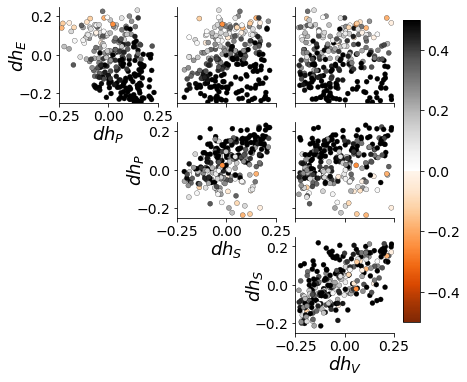

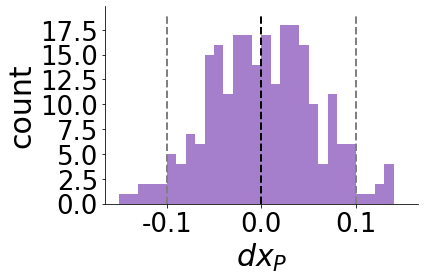

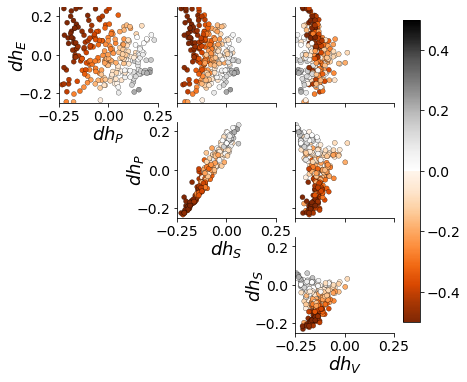

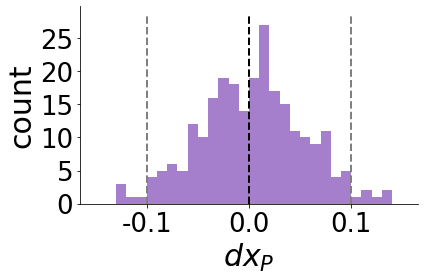

In [121]:
import matplotlib
from matplotlib.colors import ListedColormap

figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/Fig3/"

dt = 0.00025
# Define model
alphas = ['P']
contrasts = [0., 1.]
eps = 0.01
isn_lim = 0.5

top = matplotlib.cm.get_cmap('Oranges_r', 128)
bottom = matplotlib.cm.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
cmap = ListedColormap(newcolors, name='OrangeGray')

for alpha in alphas:
    for contrast in contrasts:
        path = max_H_paths[(alpha, contrast, eps)]
        best_k = max_H_ks[(alpha, contrast, eps)]

        ind = 1070
        hb = load_SSSN_variable('hb', ind=ind)
        hc = load_SSSN_variable('hc', ind=ind)
        H = (hb + contrast*hc)[None,:]

        neuron_ind = neuron_inds[alpha]

        name = "SSSN_drdh_%s_c=%.1f_eps=%.3f" % (alpha, contrast, eps)
        dh = Parameter("dh", D, lb=lb, ub=ub)
        parameters = [dh]
        model = Model(name, parameters)

        # Define eps
        def dr(dh):
            x1 = sssn_sim(H + tf.zeros_like(dh))[:,:,neuron_ind]
            x2 = sssn_sim(H + dh)[:,:,neuron_ind]

            diff = tf.reduce_mean(x2 - x1, axis=1)
            T_x = tf.stack((diff, diff ** 2), axis=1)

            return T_x

        model.set_eps(dr)

        epi_df = model.get_epi_df()
        epi_df2 = epi_df[epi_df['path'] == path]
        df_row = epi_df2.iloc[0].copy()
        dist = model.get_epi_dist(df_row, k=best_k)

        z, log_q_z = dist.nf(250)
        T_x = model.eps(z).numpy()
        z = z.numpy()
        log_q_z = log_q_z.numpy()

        isn_coeffs = ISN_coeff(z, H).numpy()

        neurons = [alpha for alpha in neuron_inds.keys()]
        labels = [r'$dh_%s$' % alpha for alpha in neurons]
        fig, axs, = pairplot(z, range(4), labels, s=25, figsize=(6,6),
                             fontsize=18, lb=dist.nf.lb, ub=dist.nf.ub,
                             norm=matplotlib.colors.Normalize(vmin=-isn_lim, vmax=isn_lim, clip=True),
                             outlier_stds=3, labelpads=(0,-10), cmap=cmap, #cmap=plt.get_cmap('coolwarm'),
                             c=isn_coeffs, c_label='')
        plt.savefig(figdir + name + '_z_isn.png')

        plot_T_x(None, T_x[:,0], x_mean=0., x_std=mu_std, 
                 xmin=-3.*mu_std, xmax=3.*mu_std, 
                 xlabel=r'$dx_%s$' % alpha, 
                 fontsize=30)
        plt.tight_layout()
        plt.savefig(figdir + name + '_T_x_isn.png')


[array([0., 0., 0., 1.])]


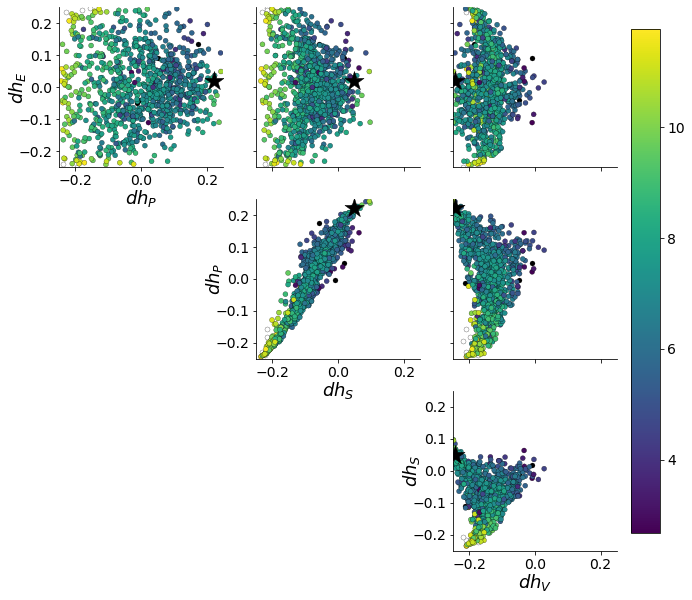

In [45]:
pos_isn = np.logical_and(isn_coeffs > .1, z[:,1] < .225)
#pos_isn = isn_coeffs > 0.0
z_pos_isn = z[pos_isn]
log_q_z_pos_isn = log_q_z[pos_isn]
mode_pos_isn = np.argmax(log_q_z_pos_isn)
z_mode_pos_isn = z_pos_isn[mode_pos_isn]
z_stars = z_mode_pos_isn[None,:]
alpha_c_star = 1.
c_stars = [np.concatenate((np.array([0,0,0]), np.array([alpha_c_star])))]
             #np.concatenate((.7*np.ones((3,)), np.array([alpha_c_star])))]
print(c_stars)
fig, axs, = pairplot(z, range(4), labels, s=25, figsize=(10,10),
                     fontsize=18, lb=dist.nf.lb, ub=dist.nf.ub,
                     starred=z_stars, c_starred=c_stars,
                     outlier_stds=3, labelpads=(0,-10),
                         c=log_q_z, c_label='')
#plt.savefig(figdir + name + '_z_isn.png')

In [46]:
print(H)

tf.Tensor([[1.1851931 0.9004071 0.5148208 0.6697344]], shape=(1, 4), dtype=float32)


-193614.17 [ 0.05156496 -0.87525356  0.4623556  -0.13228573] 1.9836577189830775


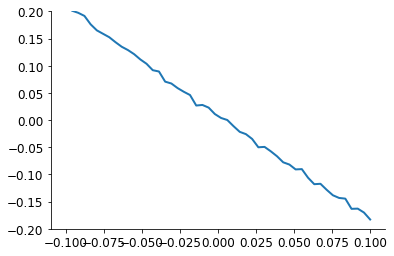

-43867.277 [ 0.01121061 -0.05088257  0.18329716  0.9816758 ] 0.1810517833126095


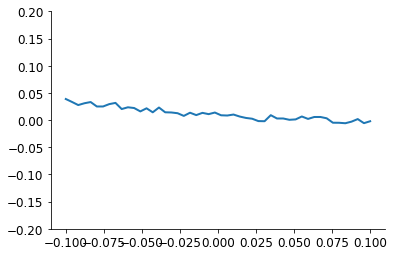

-268.59616 [ 0.6241859   0.40234652  0.6606736  -0.10963362] 0.4702620372258601


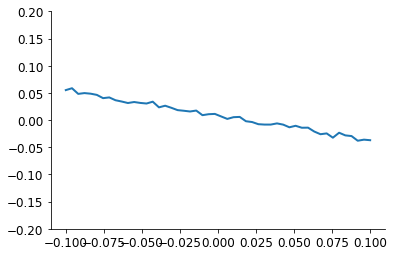

-78.119125 [ 0.77949166 -0.2635515  -0.5622631   0.08242281] 0.49340533701287204


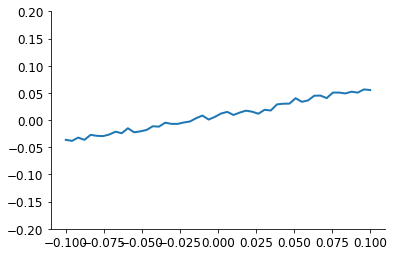

In [49]:
hess_z = dist.hessian(z_stars)
w, v = np.linalg.eigh(hess_z[0])
alphas = np.linspace(-.1, .1, 50)[:,None].astype(np.float32)
sssn_sim = SSSN_sim(eps, N=100)
def dr(dh):
    x1 = sssn_sim(H + tf.zeros_like(dh, dtype=tf.float32))[:,:,neuron_ind]
    x2 = sssn_sim(H + dh)[:,:,neuron_ind]

    diff = tf.reduce_mean(x2 - x1, axis=1)
    T_x = tf.stack((diff, diff ** 2), axis=1)

    return T_x

def SSSN_sensitivity(v, lim=.1):
    alphas = np.linspace(-lim, lim, 50)[:,None].astype(np.float32)
    z_perturb = z_mode_pos_isn + alphas*v[None,:]
    T_x_perturb = dr(z_perturb)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(alphas[:,0], T_x_perturb[:,0])
    return np.abs(slope)

for i, _w in enumerate(w):
    v_i = v[:,i]
    s_i = SSSN_sensitivity(v[:,i])
    print(_w, v_i, s_i)
    z_perturb = z_mode_pos_isn + alphas*v_i[None,:]
    T_x_perturb = dr(z_perturb)
    plt.figure()
    plt.plot(alphas, T_x_perturb[:,0])
    plt.ylim([-.2, .2])
    plt.show()
   


(array([12.,  8., 11.,  9., 15., 18.,  4.,  8.,  7.,  8.]),
 array([1.53844020e-03, 1.90674867e-01, 3.79811293e-01, 5.68947720e-01,
        7.58084146e-01, 9.47220573e-01, 1.13635700e+00, 1.32549343e+00,
        1.51462985e+00, 1.70376628e+00, 1.89290271e+00]),
 <BarContainer object of 10 artists>)

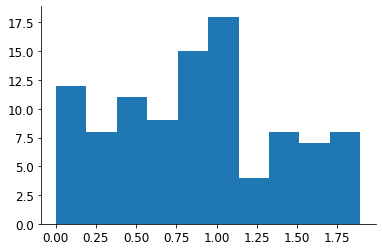

In [50]:
import scipy.stats
M_rand = 100
v_rand = np.random.normal(0., 1., (M_rand, 4))
v_rand = v_rand/ np.linalg.norm(v_rand, axis=1)[:,None]

null_sens = [SSSN_sensitivity(v_rand[i]) for i in range(M_rand)]

plt.hist(null_sens)
    

ISN tf.Tensor([0.2865168], shape=(1,), dtype=float32)


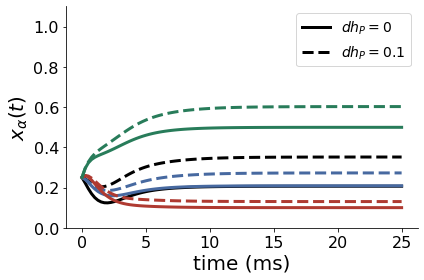

ISN tf.Tensor([-0.23586798], shape=(1,), dtype=float32)


No handles with labels found to put in legend.


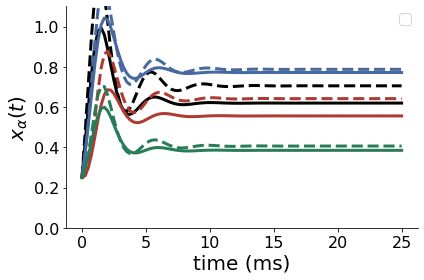

In [49]:
dhP = np.zeros((1,4))
dhP[0,1] = 0.1
for c_ind, contrast in enumerate(contrasts):
    H = (hb + contrast*hc)[None,:]
    isn_coeff = ISN_coeff(np.zeros((1,4)), H)
    print("ISN", isn_coeff)
    fig, ax = plt.subplots(1,1)
    for neuron in neurons:
        r_t = sssn_sim_traj_det(H)[0,0,:4]
        r_t_Pinc = sssn_sim_traj_det(H+dhP)[0,0,:4]
        ind = neuron_inds[neuron]
        if c_ind == 0 and neuron == 'E':
            label_det = r'$dh_P = 0$'
            label_rand = r'$dh_P = 0.1$'
        else:
            label_det = None
            label_rand = None
        ax.plot(1e3*t, r_t[ind], '-', c=colors[ind], 
                 lw=3, label=label_det)
        ax.plot(1e3*t, r_t_Pinc[ind], '--', c=colors[ind], 
                 lw=3, label=label_rand)
    plt.setp(ax.get_xticklabels(), fontsize=(fontsize-4))
    plt.setp(ax.get_yticklabels(), fontsize=(fontsize-4))
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$x_\alpha(t)$', fontsize=fontsize)
    ax.legend()
    ax.set_ylim(ylims)
    plt.tight_layout()
    #plt.savefig(figdir + "3D.png")
    plt.show()